In [1]:
library('tidyverse')
library('ggrepel')
library('ggbeeswarm')
library('readxl')
library('limma')
library('edgeR')

org_opts <- options()

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.3.0      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
custom_design <-
    read_csv(
        'custom_design.csv',
        col_types=cols(
            `pseudotime`=col_factor(levels=c('begin', 'end')),
            `uid`=col_character(),
            `exp_label`=col_factor(levels=c('UT', 'CytoTIL15'))
        )
    )

custom_design

pseudotime,uid,exp_label
<fct>,<chr>,<fct>
end,89164T006_S53_293 - 25uM,CytoTIL15
end,89164T006_S54_292,CytoTIL15
end,89164T006_S51_UT,UT
begin,89164T006_S33_293 - 25uM,CytoTIL15
begin,89164T006_S36_292,CytoTIL15
begin,89164T006_S30_UT,UT


In [3]:
metadata <-
    read_csv('006_metadata.csv') %>%
    left_join(custom_design, by='uid') %>%
    filter(
        !is.na(`exp_label`),
        str_detect(`Patient`, '006')
    )

metadata

Rows: 23 Columns: 16
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (9): CRO name, Sample Name, Display Name, TIL, Group, Population, Time P...
dbl (5): Sample #, ACZ dose, ACZ dose simple, Day, CD8_fraction
lgl (2): exclude_reason, Tumor reactive

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Sample #,CRO name,Sample Name,Display Name,TIL,ACZ dose,ACZ dose simple,Group,Population,Time Point,Day,exclude_reason,CD8_fraction,Patient,Tumor reactive,uid,pseudotime,exp_label
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<lgl>,<dbl>,<chr>,<lgl>,<chr>,<fct>,<fct>
30,S30,UT non-sorted,Day 0 - UT non-sorted,UT,NA,NA,UT,All,Day 0,0,NA,73.70,89164T006,NA,89164T006_S30_UT,begin,UT
33,S33,293 non-sorted,Day 0 - 293 non-sorted,293,NA,NA,293 - 25uM,All,Day 0,0,NA,88.85,89164T006,NA,89164T006_S33_293 - 25uM,begin,CytoTIL15
36,S36,292 non-sorted,Day 0 - 292 non-sorted,292,NA,NA,292,All,Day 0,0,NA,88.15,89164T006,NA,89164T006_S36_292,begin,CytoTIL15
51,S51,UT 3000 IU/mL IL-2,Day 28 - UT 3000 IU/mL IL-2,UT,NA,NA,UT,All,Day 28,28,NA,91.80,89164T006,NA,89164T006_S51_UT,end,UT
53,S53,293 - 25uM ACZ,Day 28 - 293 - 25uM ACZ,293 - 25uM,25,2,293 - 25uM,All,Day 28,28,NA,89.70,89164T006,NA,89164T006_S53_293 - 25uM,end,CytoTIL15
54,S54,292,Day 28 - 292,292,NA,NA,292,All,Day 28,28,NA,84.10,89164T006,NA,89164T006_S54_292,end,CytoTIL15


In [4]:
combined_results_tbl <-
    read_csv('006-gene_expressions-est_counts.csv') %>%
    select(`gene_symbol`, all_of(metadata$`uid`))

combined_results_tbl %>%
    head()

Rows: 35587 Columns: 29
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): gene_symbol
dbl (28): 89164T006_S28_UT, 89164T006_S30_UT, 89164T006_S30_UT - no IL2, 891...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


gene_symbol,89164T006_S30_UT,89164T006_S33_293 - 25uM,89164T006_S36_292,89164T006_S51_UT,89164T006_S53_293 - 25uM,89164T006_S54_292
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,30.575020,68.660516,59.621360,18.643386,33.834540,16.0329760
A1CF,1.521734,2.241660,1.610806,1.109688,2.215024,0.7096240
A2M,2.615385,18.307688,15.211231,3.153847,10.119663,3.7692315
A2ML1,2.414774,3.672967,4.413311,2.545211,3.628641,0.8049267
A2MP1,7.250003,41.750100,29.000000,3.250000,18.499995,11.7499925
A3GALT2,1.000000,9.000000,9.000000,0.000000,8.000000,2.0000000


In [5]:
prerep_matrix <-
    combined_results_tbl %>%
    filter(
        !str_detect(`gene_symbol`, '^TR[ABDG][JVC][0-9]*')
    )

target_names <- prerep_matrix %>% pull(`gene_symbol`)
prerep_matrix <- as.matrix(prerep_matrix %>% select(-`gene_symbol`))
rownames(prerep_matrix) <- target_names

prerep_matrix %>%
    head()

,89164T006_S30_UT,89164T006_S33_293 - 25uM,89164T006_S36_292,89164T006_S51_UT,89164T006_S53_293 - 25uM,89164T006_S54_292
A1BG,30.575020,68.660516,59.621360,18.643386,33.834540,16.0329760
A1CF,1.521734,2.241660,1.610806,1.109688,2.215024,0.7096240
A2M,2.615385,18.307688,15.211231,3.153847,10.119663,3.7692315
A2ML1,2.414774,3.672967,4.413311,2.545211,3.628641,0.8049267
A2MP1,7.250003,41.750100,29.000000,3.250000,18.499995,11.7499925
A3GALT2,1.000000,9.000000,9.000000,0.000000,8.000000,2.0000000


In [6]:
exp_model <-
    left_join(
        tibble(`uid`=colnames(prerep_matrix)),
        metadata,
        by='uid'
    ) %>%
    model.matrix(data=., ~`exp_label`)

exp_model

,(Intercept),exp_labelCytoTIL15
1,1,0
2,1,1
3,1,1
4,1,0
5,1,1
6,1,1


In [7]:
dge <-
    DGEList(prerep_matrix) %>%
    calcNormFactors()

keep <- filterByExpr(dge, exp_model)
dge <- dge[keep,, keep.lib.sizes=FALSE]
vdge <- voom(dge, exp_model)
all_fit <- lmFit(vdge, exp_model) %>% eBayes

In [8]:
coefficients(all_fit) %>% colnames()

[1] "(Intercept)"        "exp_labelCytoTIL15"

In [9]:
all_table <-
    topTable(all_fit, adjust.method='fdr', n=nrow(prerep_matrix), sort.by='p', coef='exp_labelCytoTIL15') %>%
    rownames_to_column(var='gene_symbol') %>%
    as_tibble() 

all_table %>%
    head(50)

gene_symbol,logFC,AveExpr,t,P.Value,adj.P.Val,B
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FREM2,-3.0472952,2.5153920,-14.942845,2.924430e-06,0.03924000,3.94842654
ITGAM,1.9407014,6.0858723,11.226059,1.752172e-05,0.07217070,3.64185885
SIX4,-1.6075926,4.5650403,-10.845154,2.169298e-05,0.07217070,3.45048677
STC1,-2.9754995,1.7220406,-10.346317,2.899694e-05,0.07217070,1.99214964
CREG1,-1.3975445,6.0437660,-9.901344,3.797339e-05,0.07217070,2.95421004
TRIB2,1.4163472,5.9055331,9.863128,3.888273e-05,0.07217070,2.92460066
RDH10,-1.5824186,8.2558097,-9.747496,4.178988e-05,0.07217070,2.83553558
TFEC,-2.7856978,3.0025746,-9.593528,4.605570e-05,0.07217070,2.55694261
HHLA2,-2.5847542,2.8610655,-9.515462,4.840783e-05,0.07217070,2.48272079


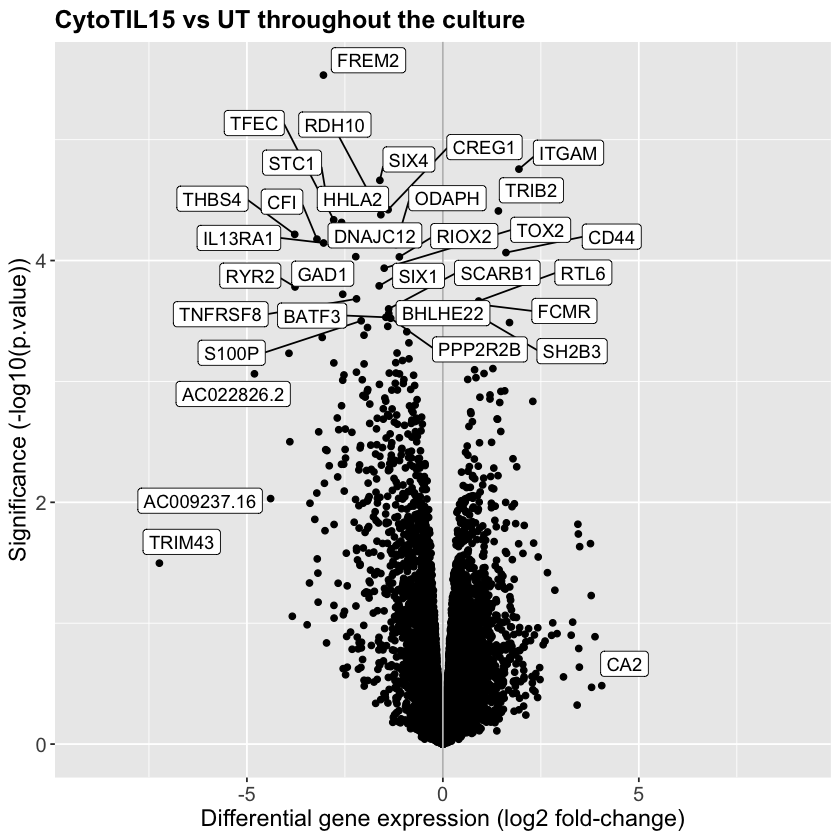

In [10]:
all_table %>%
    mutate(
        `label`=case_when(
            abs(`logFC`) >= 4 ~ str_replace_all(`gene_symbol`, ',.*', ''),
            -log10(`P.Value`) > 3.5 ~ str_replace_all(`gene_symbol`, ',.*', ''),
            TRUE ~ ''
        )
    ) %>%
    ggplot(aes(x=`logFC`, y=-log10(`P.Value`))) +
        geom_point() +
        geom_vline(xintercept=0, color='gray') +
        geom_label_repel(aes(label=`label`), max.overlaps=Inf, force=10) +
        labs(
            x='Differential gene expression (log2 fold-change)',
            y='Significance (-log10(p.value))',
            title='CytoTIL15 vs UT throughout the culture'
        ) +
        xlim(-9, 9) +
        theme(
            axis.text=element_text(size=12),
            axis.title=element_text(size=14),
            strip.text.x = element_text(size=15, face="bold"),
            plot.title = element_text(size=15, face="bold")
        )

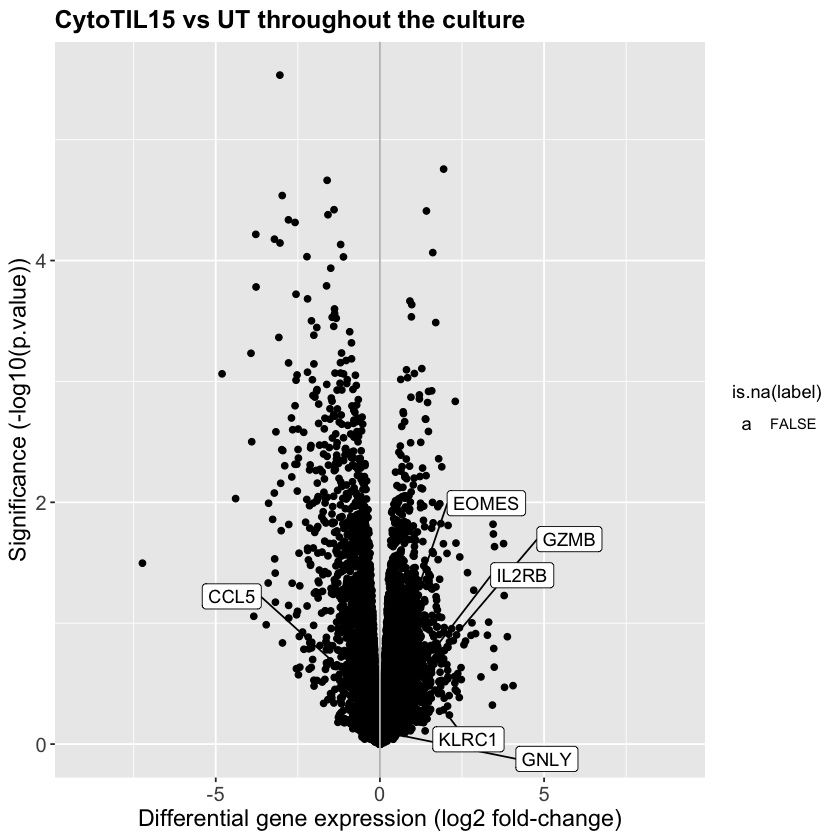

In [11]:
dge_gois <- c('KLRC1', 'GNLY', 'CCL5', 'GZMB', 'EOMES', 'TCF1', 'IL2RB')

all_table %>%
    mutate(
        `label`=case_when(
            `gene_symbol` %in% dge_gois ~ `gene_symbol`,
            TRUE ~ ''
        )
    ) %>%
    ggplot(aes(x=`logFC`, y=-log10(`P.Value`), color=is.na(`label`))) +
        geom_point() +
        geom_vline(xintercept=0, color='gray') +
        geom_label_repel(aes(label=`label`), max.overlaps=Inf, force=1) +
        labs(
            x='Differential gene expression (log2 fold-change)',
            y='Significance (-log10(p.value))',
            title='CytoTIL15 vs UT throughout the culture'
        ) +
        xlim(-9, 9) +
        scale_color_manual(values=c('black', 'maroon')) +
        theme(
            axis.text=element_text(size=12),
            axis.title=element_text(size=14),
            strip.text.x = element_text(size=15, face="bold"),
            plot.title = element_text(size=15, face="bold")
        )


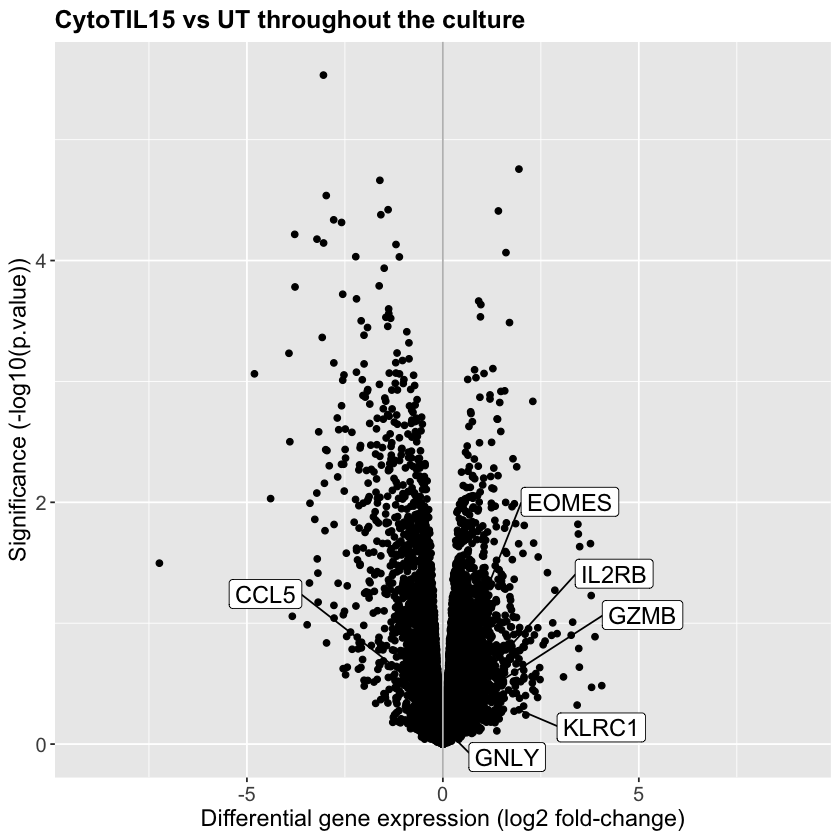

In [12]:
dge_gois <- c('KLRC1', 'GNLY', 'CCL5', 'GZMB', 'EOMES', 'TCF1', 'IL2RB')

all_table %>%
    mutate(
        `label`=case_when(
            `gene_symbol` %in% dge_gois ~ `gene_symbol`,
            TRUE ~ ''
        )
    ) %>%
    ggplot(aes(x=`logFC`, y=-log10(`P.Value`))) +
        geom_point() +
        geom_vline(xintercept=0, color='gray') +
        geom_label_repel(aes(label=`label`), max.overlaps=Inf, force=1, size=5) +
        labs(
            x='Differential gene expression (log2 fold-change)',
            y='Significance (-log10(p.value))',
            title='CytoTIL15 vs UT throughout the culture'
        ) +
        xlim(-9, 9) +
        theme(
            axis.text=element_text(size=12),
            axis.title=element_text(size=14),
            strip.text.x = element_text(size=15, face="bold"),
            plot.title = element_text(size=15, face="bold")
        )
